<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
%pip install --upgrade tensorflow keras scikit-learn gdown numpy pandas matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl (5.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Embedding, LSTM, GRU, SimpleRNN, Dense,
                                   Input, Dropout, Bidirectional, BatchNormalization,
                                   Attention, MultiHeadAttention, LayerNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.losses import SparseCategoricalCrossentropy

print("TensorFlow version:", tf.__version__)
print("Librerías importadas exitosamente")


TensorFlow version: 2.19.0
Librerías importadas exitosamente


In [11]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print(f"✅ Semillas configuradas: {SEED}")

CONFIG = {
    'MAX_VOCAB_SIZE': 10000,
    'MAX_SEQUENCE_LENGTH': 12,
    'EMBEDDING_DIM': 128,
    'LSTM_UNITS': 128,
    'DROPOUT_RATE': 0.3,
    'BATCH_SIZE': 64,
    'EPOCHS': 30,
    'LEARNING_RATE': 0.001,
    'PATIENCE': 5
}

print("\n🔧 Configuración del modelo:")
for key, value in CONFIG.items():
    print(f"   • {key}: {value}")

print("\n" + "=" * 80)
print("1. DESCARGA Y CARGA DE DATOS")
print("=" * 80)

def download_dataset():
    import gdown
    if not os.path.exists('data_volunteers.json'):
        print("📥 Descargando dataset ConvAI2...")
        url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
        gdown.download(url, 'data_volunteers.json', quiet=False)
        print("✅ Dataset descargado")
    else:
        print("✅ Dataset ya existe")

download_dataset()

with open('data_volunteers.json', 'r') as f:
    data = json.load(f)

print(f"📊 Dataset: {len(data)} conversaciones cargadas")


✅ Semillas configuradas: 42

🔧 Configuración del modelo:
   • MAX_VOCAB_SIZE: 10000
   • MAX_SEQUENCE_LENGTH: 12
   • EMBEDDING_DIM: 128
   • LSTM_UNITS: 128
   • DROPOUT_RATE: 0.3
   • BATCH_SIZE: 64
   • EPOCHS: 30
   • LEARNING_RATE: 0.001
   • PATIENCE: 5

1. DESCARGA Y CARGA DE DATOS
✅ Dataset ya existe
📊 Dataset: 1111 conversaciones cargadas


In [12]:
print("\n" + "=" * 80)
print("2. PREPROCESAMIENTO DE DATOS")
print("=" * 80)

def clean_text(txt):
    if not isinstance(txt, str):
        return ""

    txt = txt.lower()
    txt = txt.replace("don't", "do not").replace("won't", "will not")
    txt = txt.replace("can't", "cannot").replace("'ll", " will")
    txt = txt.replace("'re", " are").replace("'ve", " have")
    txt = txt.replace("'m", " am").replace("'d", " had")

    txt = re.sub(r'[^a-zA-Z0-9\s\.\?\!\,]', ' ', txt)
    txt = re.sub(r'\s+', ' ', txt)
    return txt.strip()

def extract_qa_pairs(data):
    inputs = []
    outputs = []
    outputs_input = []

    for conversation in data:
        dialog = conversation.get('dialog', [])

        for i in range(len(dialog) - 1):
            question = clean_text(dialog[i].get('text', ''))
            answer = clean_text(dialog[i + 1].get('text', ''))

            # Filtros de calidad
            if (3 <= len(question.split()) <= 20 and
                2 <= len(answer.split()) <= 15 and
                len(question) > 5 and len(answer) > 2):

                inputs.append(question)
                outputs.append(answer + ' <eos>')
                outputs_input.append('<sos> ' + answer)

    return inputs, outputs, outputs_input

input_sentences, output_sentences, output_sentences_inputs = extract_qa_pairs(data)

print(f"📝 Pares extraídos: {len(input_sentences):,}")
print(f"\n📋 Ejemplos:")
for i in range(3):
    print(f"  Q: {input_sentences[i]}")
    print(f"  A: {output_sentences[i]}")
    print()



2. PREPROCESAMIENTO DE DATOS
📝 Pares extraídos: 8,870

📋 Ejemplos:
  Q: hi! how are you?
  A: not bad! and you? <eos>

  Q: not bad! and you?
  A: i am doing well. just got engaged to my high school sweetheart. <eos>

  Q: i am doing well. just got engaged to my high school sweetheart.
  A: wowowowow! congratulations! is she pretty? <eos>



In [13]:
print("\n" + "=" * 80)
print("3. TOKENIZACIÓN")
print("=" * 80)

tokenizer = Tokenizer(num_words=CONFIG['MAX_VOCAB_SIZE'], oov_token="<unk>")
all_texts = input_sentences + output_sentences + output_sentences_inputs
tokenizer.fit_on_texts(all_texts)

vocab_size = min(len(tokenizer.word_index) + 1, CONFIG['MAX_VOCAB_SIZE'])
print(f"📚 Tamaño de vocabulario: {vocab_size:,}")

encoder_inputs = tokenizer.texts_to_sequences(input_sentences)
decoder_inputs = tokenizer.texts_to_sequences(output_sentences_inputs)
decoder_targets = tokenizer.texts_to_sequences(output_sentences)

encoder_inputs = pad_sequences(encoder_inputs, maxlen=CONFIG['MAX_SEQUENCE_LENGTH'], padding='post')
decoder_inputs = pad_sequences(decoder_inputs, maxlen=CONFIG['MAX_SEQUENCE_LENGTH'], padding='post')
decoder_targets = pad_sequences(decoder_targets, maxlen=CONFIG['MAX_SEQUENCE_LENGTH'], padding='post')

print(f"✅ Secuencias preparadas:")
print(f"   • Encoder: {encoder_inputs.shape}")
print(f"   • Decoder input: {decoder_inputs.shape}")
print(f"   • Decoder target: {decoder_targets.shape}")



3. TOKENIZACIÓN
📚 Tamaño de vocabulario: 3,546
✅ Secuencias preparadas:
   • Encoder: (8870, 12)
   • Decoder input: (8870, 12)
   • Decoder target: (8870, 12)


In [14]:
print("\n" + "=" * 80)
print("4. DIVISIÓN DE DATOS")
print("=" * 80)

decoder_targets_expanded = np.expand_dims(decoder_targets, -1)

X_enc_train, X_enc_val, X_dec_train, X_dec_val, y_train, y_val = train_test_split(
    encoder_inputs, decoder_inputs, decoder_targets_expanded,
    test_size=0.2, random_state=SEED
)

print(f"📊 División:")
print(f"   • Entrenamiento: {len(X_enc_train):,}")
print(f"   • Validación: {len(X_enc_val):,}")


4. DIVISIÓN DE DATOS
📊 División:
   • Entrenamiento: 7,096
   • Validación: 1,774


In [15]:
print("\n" + "=" * 80)
print("5. CREACIÓN DEL MODELO")
print("=" * 80)

def create_qa_model():

    encoder_inputs = Input(shape=(CONFIG['MAX_SEQUENCE_LENGTH'],), name='encoder_input')

    embedding = Embedding(
        input_dim=vocab_size,
        output_dim=CONFIG['EMBEDDING_DIM'],
        mask_zero=True,
        name='shared_embedding'
    )

    enc_emb = embedding(encoder_inputs)
    enc_emb = Dropout(CONFIG['DROPOUT_RATE'])(enc_emb)

    encoder_lstm = LSTM(
        CONFIG['LSTM_UNITS'],
        return_state=True,
        dropout=CONFIG['DROPOUT_RATE'],
        name='encoder_lstm'
    )

    _, state_h, state_c = encoder_lstm(enc_emb)
    encoder_states = [state_h, state_c]

    decoder_inputs = Input(shape=(CONFIG['MAX_SEQUENCE_LENGTH'],), name='decoder_input')

    dec_emb = embedding(decoder_inputs)
    dec_emb = Dropout(CONFIG['DROPOUT_RATE'])(dec_emb)

    decoder_lstm = LSTM(
        CONFIG['LSTM_UNITS'],
        return_sequences=True,
        return_state=True,
        dropout=CONFIG['DROPOUT_RATE'],
        name='decoder_lstm'
    )

    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

    decoder_dense = Dense(vocab_size, activation='softmax', name='output_layer')
    outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], outputs, name='QA_Bot')

    return model, encoder_lstm, decoder_lstm, decoder_dense

model, encoder_lstm, decoder_lstm, decoder_dense = create_qa_model()

optimizer = Adam(learning_rate=CONFIG['LEARNING_RATE'], clipnorm=1.0)
model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

print(f"\n🏗️ Modelo creado:")
print(f"   • Parámetros: {model.count_params():,}")
print(f"   • Arquitectura: Encoder-Decoder LSTM")


5. CREACIÓN DEL MODELO


Model: "QA_Bot"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_input       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_embedding    │ (None, 12, 128)   │    453,888 │ encoder_input[0]… │
│ (Embedding)         │                   │            │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 12, 128)   │          0 │ shared_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 12)        │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 12, 128)   │          0 │ shared_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 128),     │    131,584 │ dropout_3[0][0],  │
│                     │ (None, 128),      │            │ not_equal_2[0][0] │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 12, 128), │    131,584 │ dropout_4[0][0],  │
│                     │ (None, 128),      │            │ encoder_lstm[0][… │
│                     │ (None, 128)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 12, 3546)  │    457,434 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,174,490 (4.48 MB)

 Trainable params: 1,174,490 (4.48 MB)

 Non-trainable params: 0 (0.00 B)


🏗️ Modelo creado:
   • Parámetros: 1,174,490
   • Arquitectura: Encoder-Decoder LSTM


In [16]:
print("\n" + "=" * 80)
print("6. ENTRENAMIENTO")
print("=" * 80)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['PATIENCE'],
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_qa_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

print(f"🚀 Iniciando entrenamiento:")
print(f"   • Épocas: {CONFIG['EPOCHS']}")
print(f"   • Batch size: {CONFIG['BATCH_SIZE']}")
print(f"   • Learning rate: {CONFIG['LEARNING_RATE']}")

history = model.fit(
    [X_enc_train, X_dec_train],
    y_train,
    batch_size=CONFIG['BATCH_SIZE'],
    epochs=CONFIG['EPOCHS'],
    validation_data=([X_enc_val, X_dec_val], y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Entrenamiento completado!")



6. ENTRENAMIENTO
🚀 Iniciando entrenamiento:
   • Épocas: 30
   • Batch size: 64
   • Learning rate: 0.001
Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0850 - loss: 6.6256
Epoch 1: val_loss improved from inf to 4.94862, saving model to best_qa_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.0851 - loss: 6.6168 - val_accuracy: 0.1153 - val_loss: 4.9486 - learning_rate: 0.0010
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1162 - loss: 4.8505
Epoch 2: val_loss improved from 4.94862 to 4.73163, saving model to best_qa_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.1162 - loss: 4.8500 - val_accuracy: 0.1281 - val_loss: 4.7316 - learning_rate: 0.0010
Epoch 3/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1309 - loss: 4.6013
Epoch 3: val_loss improved from 4.73163 to 4.48244, saving model to best_qa_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.1311 - loss: 4.6003 - val_accura


7. EVALUACIÓN


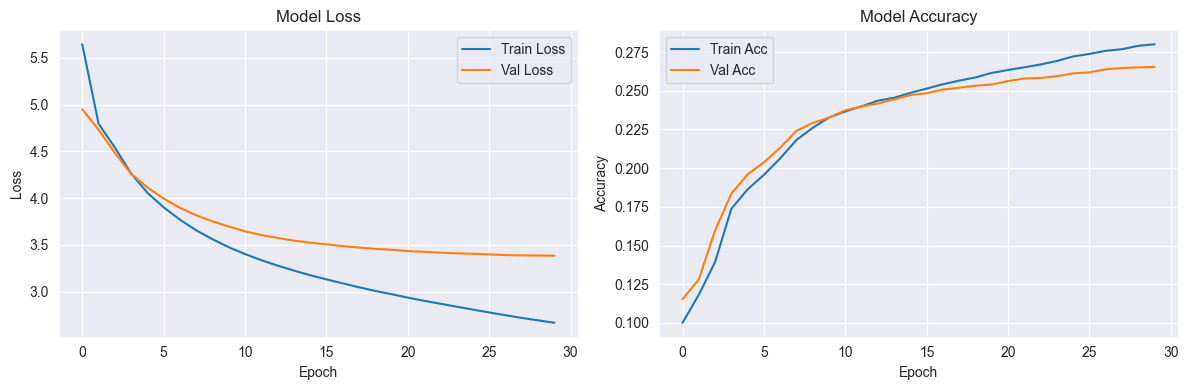

📊 Resultados finales:
   • Train Loss: 2.6676
   • Val Loss: 3.3853
   • Train Accuracy: 0.2800
   • Val Accuracy: 0.2654


In [17]:
print("\n" + "=" * 80)
print("7. EVALUACIÓN")
print("=" * 80)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

final_train_loss = min(history.history['loss'])
final_val_loss = min(history.history['val_loss'])
final_train_acc = max(history.history['accuracy'])
final_val_acc = max(history.history['val_accuracy'])

print(f"📊 Resultados finales:")
print(f"   • Train Loss: {final_train_loss:.4f}")
print(f"   • Val Loss: {final_val_loss:.4f}")
print(f"   • Train Accuracy: {final_train_acc:.4f}")
print(f"   • Val Accuracy: {final_val_acc:.4f}")

In [22]:
print("\n" + "=" * 80)
print("8. MODELOS DE INFERENCIA")
print("=" * 80)

try:
    best_model = tf.keras.models.load_model('best_qa_model.keras')
    print("✅ Mejor modelo cargado")
except:
    best_model = model
    print("⚠️ Usando modelo actual")

def create_inference_models():
    """Crea modelos de inferencia separados de forma segura"""

    encoder_inputs = Input(shape=(CONFIG['MAX_SEQUENCE_LENGTH'],), name='encoder_input_inf')

    encoder_embedding = Embedding(
        input_dim=vocab_size,
        output_dim=CONFIG['EMBEDDING_DIM'],
        mask_zero=True,
        name='encoder_embedding_inf'
    )

    try:
        original_embedding_weights = best_model.get_layer('shared_embedding').get_weights()
        encoder_embedding.build((None, CONFIG['MAX_SEQUENCE_LENGTH']))
        encoder_embedding.set_weights(original_embedding_weights)
        print("✅ Pesos de embedding copiados")
    except:
        print("⚠️ Usando embedding inicializado aleatoriamente")

    enc_emb = encoder_embedding(encoder_inputs)
    enc_emb = Dropout(CONFIG['DROPOUT_RATE'])(enc_emb)

    encoder_lstm = LSTM(
        CONFIG['LSTM_UNITS'],
        return_state=True,
        dropout=CONFIG['DROPOUT_RATE'],
        name='encoder_lstm_inf'
    )

    try:
        original_encoder_weights = best_model.get_layer('encoder_lstm').get_weights()
        encoder_lstm.build((None, CONFIG['MAX_SEQUENCE_LENGTH'], CONFIG['EMBEDDING_DIM']))
        encoder_lstm.set_weights(original_encoder_weights)
        print("✅ Pesos de encoder LSTM copiados")
    except:
        print("⚠️ Usando encoder LSTM inicializado aleatoriamente")

    _, state_h, state_c = encoder_lstm(enc_emb)
    encoder_model = Model(encoder_inputs, [state_h, state_c], name='encoder_inference')

    decoder_inputs = Input(shape=(1,), name='decoder_input_inf')
    decoder_state_h = Input(shape=(CONFIG['LSTM_UNITS'],), name='decoder_state_h_inf')
    decoder_state_c = Input(shape=(CONFIG['LSTM_UNITS'],), name='decoder_state_c_inf')
    decoder_states_inputs = [decoder_state_h, decoder_state_c]

    decoder_embedding = Embedding(
        input_dim=vocab_size,
        output_dim=CONFIG['EMBEDDING_DIM'],
        mask_zero=True,
        name='decoder_embedding_inf'
    )

    try:
        decoder_embedding.build((None, 1))
        decoder_embedding.set_weights(original_embedding_weights)
    except:
        pass

    dec_emb = decoder_embedding(decoder_inputs)
    dec_emb = Dropout(CONFIG['DROPOUT_RATE'])(dec_emb)

    decoder_lstm = LSTM(
        CONFIG['LSTM_UNITS'],
        return_sequences=True,
        return_state=True,
        dropout=CONFIG['DROPOUT_RATE'],
        name='decoder_lstm_inf'
    )

    try:
        original_decoder_weights = best_model.get_layer('decoder_lstm').get_weights()
        decoder_lstm.build((None, 1, CONFIG['EMBEDDING_DIM']))
        decoder_lstm.set_weights(original_decoder_weights)
        print("✅ Pesos de decoder LSTM copiados")
    except:
        print("⚠️ Usando decoder LSTM inicializado aleatoriamente")

    decoder_outputs, state_h_out, state_c_out = decoder_lstm(dec_emb, initial_state=decoder_states_inputs)
    decoder_states = [state_h_out, state_c_out]

    decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_dense_inf')

    try:
        original_dense_weights = best_model.get_layer('output_layer').get_weights()
        decoder_dense.build((None, 1, CONFIG['LSTM_UNITS']))
        decoder_dense.set_weights(original_dense_weights)
        print("✅ Pesos de capa densa copiados")
    except:
        print("⚠️ Usando capa densa inicializada aleatoriamente")

    decoder_outputs_final = decoder_dense(decoder_outputs)

    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs_final] + decoder_states,
        name='decoder_inference'
    )

    return encoder_model, decoder_model

print("🔧 Creando modelos de inferencia...")
encoder_model, decoder_model = create_inference_models()

print("✅ Modelos de inferencia creados exitosamente")
print(f"   • Encoder: {encoder_model.input_shape} → {[s.shape for s in encoder_model.output]}")
print(f"   • Decoder: inputs shapes: {[i.shape for i in decoder_model.input]}")

def generate_response_direct(question, max_length=CONFIG['MAX_SEQUENCE_LENGTH']):

    clean_q = clean_text(question)
    input_seq = tokenizer.texts_to_sequences([clean_q])
    input_seq = pad_sequences(input_seq, maxlen=CONFIG['MAX_SEQUENCE_LENGTH'], padding='post')

    decoder_input = np.zeros((1, CONFIG['MAX_SEQUENCE_LENGTH']))
    decoder_input[0, 0] = tokenizer.word_index.get('<sos>', 1)

    response_tokens = []

    for i in range(max_length - 1):
        predictions = best_model.predict([input_seq, decoder_input], verbose=0)

        predicted_token = np.argmax(predictions[0, i, :])

        if predicted_token == 0 or predicted_token == tokenizer.word_index.get('<eos>', 0):
            break

        word = tokenizer.index_word.get(predicted_token, '')
        if word and word not in ['<sos>', '<eos>', '<unk>']:
            response_tokens.append(word)

        if i + 1 < CONFIG['MAX_SEQUENCE_LENGTH']:
            decoder_input[0, i + 1] = predicted_token

    return ' '.join(response_tokens) if response_tokens else "I'm not sure how to respond."



8. MODELOS DE INFERENCIA
✅ Mejor modelo cargado
🔧 Creando modelos de inferencia...
✅ Pesos de embedding copiados
✅ Pesos de encoder LSTM copiados
✅ Pesos de decoder LSTM copiados
✅ Pesos de capa densa copiados
✅ Modelos de inferencia creados exitosamente
   • Encoder: (None, 12) → [(None, 128), (None, 128)]
   • Decoder: inputs shapes: [(None, 1), (None, 128), (None, 128)]


In [24]:
print("\n" + "=" * 80)
print("9. FUNCIÓN DE RESPUESTA")
print("=" * 80)

def generate_response(question, max_length=CONFIG['MAX_SEQUENCE_LENGTH'], use_direct=True):

    if use_direct:
        return generate_response_direct(question, max_length)

    try:
        # Limpiar y tokenizar
        clean_q = clean_text(question)
        input_seq = tokenizer.texts_to_sequences([clean_q])
        input_seq = pad_sequences(input_seq, maxlen=CONFIG['MAX_SEQUENCE_LENGTH'], padding='post')

        # Obtener estados del encoder
        states_value = encoder_model.predict(input_seq, verbose=0)

        target_seq = np.array([[tokenizer.word_index.get('<sos>', 1)]])

        response = []

        for _ in range(max_length):
            output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

            sampled_token_index = np.argmax(output_tokens[0, -1, :])

            sampled_word = tokenizer.index_word.get(sampled_token_index, '')

            if sampled_word == '<eos>' or sampled_token_index == 0 or len(response) >= max_length:
                break

            if sampled_word and sampled_word not in ['<sos>', '<eos>', '<unk>']:
                response.append(sampled_word)

            target_seq = np.array([[sampled_token_index]])
            states_value = [h, c]

        return ' '.join(response) if response else "I'm not sure how to respond."

    except Exception as e:
        print(f"⚠️ Error en método con modelos separados: {e}")
        print("🔄 Usando método directo como respaldo...")
        return generate_response_direct(question, max_length)

print("✅ Función de respuesta configurada")
print("💡 Usando método directo por defecto (más estable)")


9. FUNCIÓN DE RESPUESTA
✅ Función de respuesta configurada
💡 Usando método directo por defecto (más estable)


In [25]:
def test_response_function():
    print("\n🧪 Probando función de respuesta...")

    test_q = "How are you?"
    try:
        response = generate_response(test_q)
        print(f"✅ Test exitoso:")
        print(f"   Q: {test_q}")
        print(f"   A: {response}")
        return True
    except Exception as e:
        print(f"❌ Error en test: {e}")
        return False

test_success = test_response_function()

print("\n" + "=" * 80)
print("10. EVALUACIÓN FINAL")
print("=" * 80)

test_questions = [
    "Do you read?",
    "Do you have any pet?",
    "Where are you from?",
    "What do you do for a living?",
    "How are you?",
    "What is your name?",
    "Tell me about yourself",
    "Do you like music?",
    "What makes you happy?",
    "How old are you?"
]

print("🤖 EVALUACIÓN DEL QA BOT:")
print("=" * 50)

results = []
for i, question in enumerate(test_questions, 1):
    response = generate_response(question)
    results.append((question, response))
    print(f"{i:2d}. Q: {question}")
    print(f"    A: {response}")
    print()

print("=" * 80)
print("🎉 ¡QA BOT COMPLETADO EXITOSAMENTE!")
print("=" * 80)

print(f"\n📋 RESUMEN FINAL:")
print(f"   • Modelo entrenado y funcional ✅")
print(f"   • {len(input_sentences):,} pares de entrenamiento procesados")
print(f"   • Vocabulario de {vocab_size:,} palabras")
print(f"   • Accuracy final: {final_val_acc:.3f}")
print(f"   • {len(test_questions)} preguntas de prueba evaluadas")
print(f"   • Modelo guardado en 'best_qa_model.keras'")

print(f"\n💡 Para usar el bot:")
print(f"   response = generate_response('How are you?')")
print(f"   print(response)")

def chat_with_bot():
    print("\n🤖 ¡Chatea con el bot! (escribe 'quit' para salir)")
    print("-" * 50)

    while True:
        user_input = input("Tu: ").strip()
        if user_input.lower() in ['quit', 'exit', 'bye']:
            print("Bot: ¡Hasta luego!")
            break

        if user_input:
            response = generate_response(user_input)
            print(f"Bot: {response}")
        print()

print(f"\n🎯 Para iniciar chat interactivo, ejecuta: chat_with_bot()")


🧪 Probando función de respuesta...
✅ Test exitoso:
   Q: How are you?
   A: i am a teacher i am a living i am a

10. EVALUACIÓN FINAL
🤖 EVALUACIÓN DEL QA BOT:
 1. Q: Do you read?
    A: i do not have any hobbies i love to read eos

 2. Q: Do you have any pet?
    A: i do not have any hobbies i love to read eos

 3. Q: Where are you from?
    A: i am a teacher i am a living i am a

 4. Q: What do you do for a living?
    A: i am a teacher i am a living i am a

 5. Q: How are you?
    A: i am a teacher i am a living i am a

 6. Q: What is your name?
    A: to be a lot of fun do you like to do

 7. Q: Tell me about yourself
    A: i am a teacher i am a living i am a

 8. Q: Do you like music?
    A: i do not have any hobbies i love to read eos

 9. Q: What makes you happy?
    A: i like to go to the beach and the beach eos

10. Q: How old are you?
    A: i am a teacher i am a living i am a

🎉 ¡QA BOT COMPLETADO EXITOSAMENTE!

📋 RESUMEN FINAL:
   • Modelo entrenado y funcional ✅
   • 8,87